In [1]:
import torch
import os
import pickle
import yaml
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from PIL import Image, ImageFilter
import warnings
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from utils.ImageSet import ImageSet
from utils.utils_tumor import (
    gen_image_from_coords,
    get_RdYlGr_masks,
    get_largest_connected_area,
    pej_color,
    non_pej_color,
    healthy_color,
)

warnings.filterwarnings("ignore")


color2class = {
    tuple(healthy_color): "healthy",
    tuple(non_pej_color): "non pej",
    tuple(pej_color): "pej",
}

In [2]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

batch_size = config["model"]["batch_size"]
patch_size = config["patching"]["patch_size"]
colors = {
    0: config["visualization"]["colors"]["healthy"],
    1: config["visualization"]["colors"]["non_pej"],
    2: config["visualization"]["colors"]["pej"],
}
colors_TNT = {
    0: config["visualization"]["colors"]["healthy"],
    1: config["visualization"]["colors"]["pej"],
    2: config["visualization"]["colors"]["pej"],
}
classes = ["NT", "Non Pej", "Pej"]

vis_scale = config["patching"]["vis_scale"]
step = int(vis_scale * patch_size)

cmap = plt.get_cmap(config["visualization"]["color_map"])
normalizer = Normalize(0, 1)
im = cm.ScalarMappable(normalizer, cmap)

In [3]:
tumor_checkpoints = "../" + config["paths"]["pth_to_tumor_ckpts"]
patches_dir = "../" + config["paths"]["pth_to_patches"]
coords_checkpoints = "../" + config["paths"]["pth_to_coords"]
preds_wsis_results = "../" + config["paths"]["pth_to_preds_wsis"]

In [4]:
slide_name = "36I"

chkpt_coords = torch.load(f"{coords_checkpoints}/{slide_name}_coords_checkpoint.pt")
chkpt_tumor = torch.load(f"{tumor_checkpoints}/{slide_name}_preds_probas_checkpoint.pt")

In [5]:
coords_x = chkpt_tumor["coords_x"]
coords_y = chkpt_tumor["coords_y"]

[x_start, y_start, x_end, y_end] = chkpt_coords["xy_start_end"]
[real_x, real_y, real_w, real_h] = chkpt_coords["xywh_real"]
width, height = int(real_w * vis_scale), int(real_h * vis_scale)
coords_x = np.array(coords_x) * vis_scale - x_start
coords_y = np.array(coords_y) * vis_scale - y_start
y_har = chkpt_tumor["har_mean_preds"]
y_NT_NP_P = [np.array(colors[p.item()]) / 255 for p in y_har]

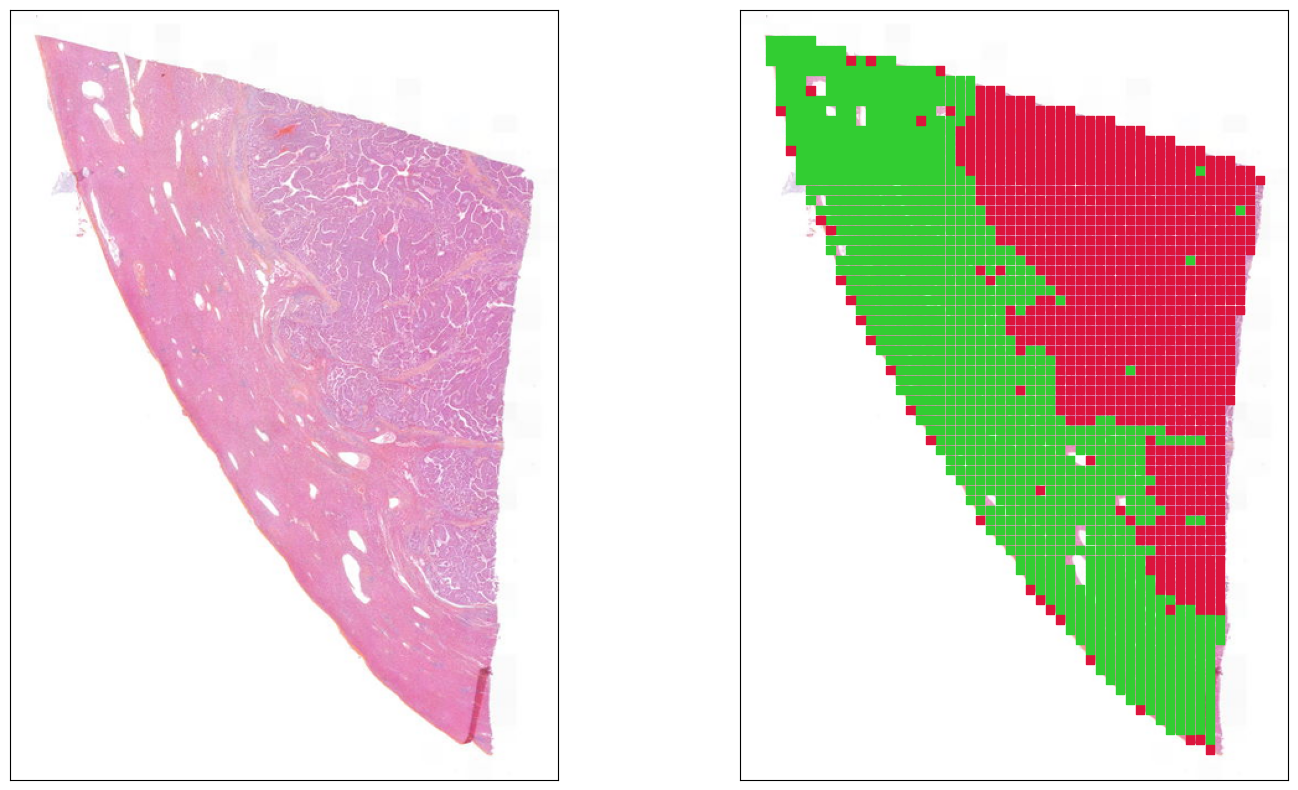

In [6]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(chkpt_tumor["scaled_slide"].astype(np.uint8))
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(chkpt_tumor["scaled_slide"].astype(np.uint8))
plt.scatter(coords_x, coords_y, c=y_NT_NP_P, marker="s")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [7]:
image = gen_image_from_coords(coords_x, coords_y, y_har, step, colors)
median_filtered = Image.fromarray(image).filter(
    ImageFilter.MedianFilter(size=2 * step + 1)
)
mode_filtered = np.array(
    Image.fromarray(image).filter(ImageFilter.ModeFilter(size=2 * step + 1))
)

masked_image_rd, masked_image_yl, masked_image_gr = get_RdYlGr_masks(mode_filtered)

(largest_zone_yl, num_px_yl) = get_largest_connected_area(
    masked_image_yl, non_pej_color
)
(largest_zone_rd, num_px_rd) = get_largest_connected_area(masked_image_rd, pej_color)
(largest_zone_gr, num_px_gr) = get_largest_connected_area(
    masked_image_gr, healthy_color
)

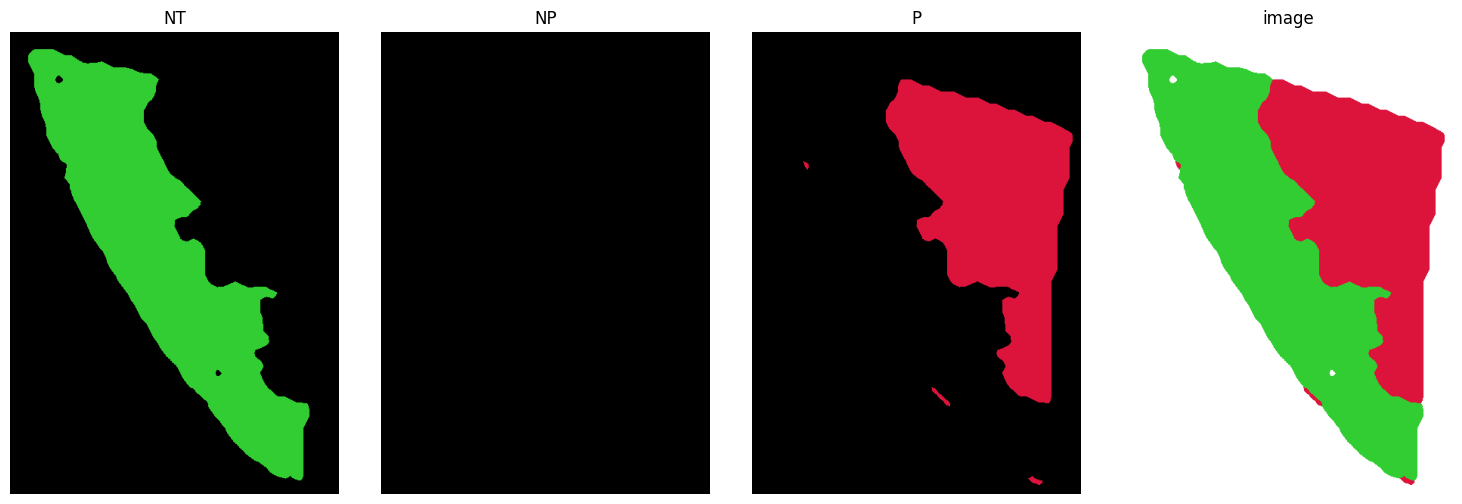

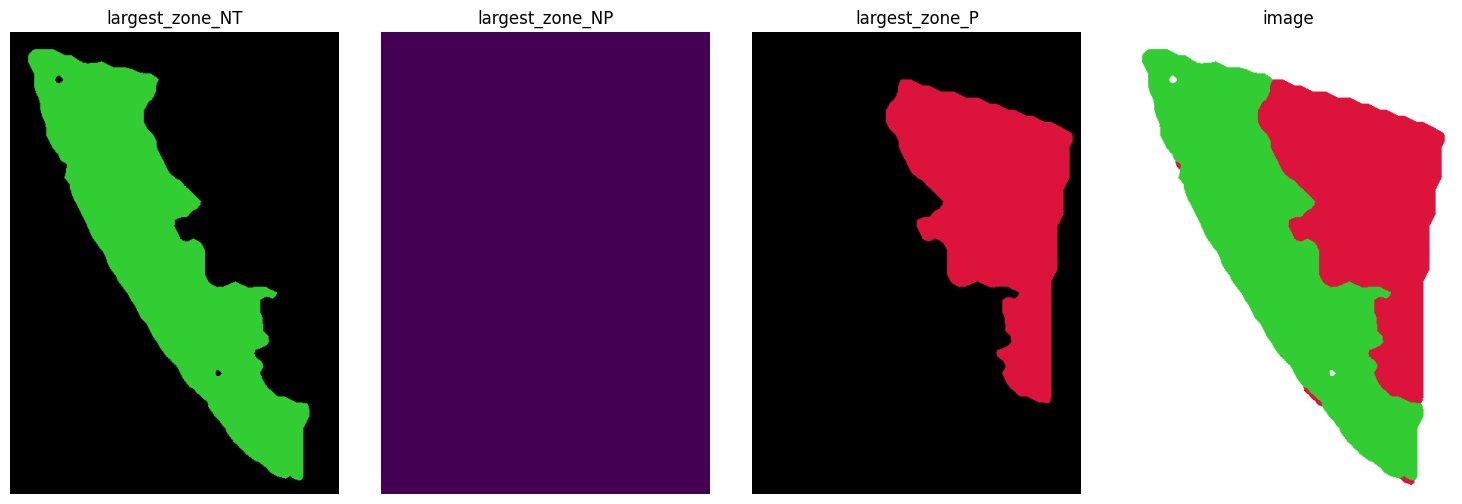

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(masked_image_gr)
axes[0].set_title("NT")
axes[0].axis("off")
axes[1].imshow(masked_image_yl)
axes[1].set_title("NP")
axes[1].axis("off")
axes[2].imshow(masked_image_rd)
axes[2].set_title("P")
axes[2].axis("off")
axes[3].imshow(mode_filtered)
axes[3].set_title("image")
axes[3].axis("off")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(largest_zone_gr)
axes[0].set_title("largest_zone_NT")
axes[0].axis("off")
axes[1].imshow(largest_zone_yl)
axes[1].set_title("largest_zone_NP")
axes[1].axis("off")
axes[2].imshow(largest_zone_rd)
axes[2].set_title("largest_zone_P")
axes[2].axis("off")
axes[3].imshow(mode_filtered)
axes[3].set_title("image")
axes[3].axis("off")
plt.tight_layout()
plt.show()

In [9]:
df = pd.DataFrame(
    columns=[
        "lame",
        "#NT",
        "#NP",
        "#P",
        "#pixels",
        "NT_CntArea",
        "NP_CntArea",
        "P_CntArea",
        "slide_w",
        "slide_h",
        "patch_size",
    ],
    index=range(1),
)

i = 0
image = gen_image_from_coords(coords_x, coords_y, y_har, step, colors)
masked_image_rd, masked_image_yl, masked_image_gr = get_RdYlGr_masks(image)

(largest_zone_yl, non_pej_area) = get_largest_connected_area(
    masked_image_yl, non_pej_color
)
(largest_zone_rd, pej_area) = get_largest_connected_area(masked_image_rd, pej_color)
(largest_zone_gr, healthy_area) = get_largest_connected_area(
    masked_image_gr, healthy_color
)

N = image.shape[0] * image.shape[1]
NonWhite_image = [
    tuple(pixel) for pixel in image.reshape(N, 3) if (pixel != (255, 255, 255)).any()
]

count = [
    (dict(Counter(NonWhite_image))[e] if e in dict(Counter(NonWhite_image)) else 0)
    for e in color2class
]


df.iloc[i] = (
    [slide_name]
    + count
    + [len(NonWhite_image)]
    + [healthy_area, non_pej_area, pej_area]
    + [real_w, real_h, 1152]
)

df

,lame,#NT,#NP,#P,#pixels,NT_CntArea,NP_CntArea,P_CntArea,slide_w,slide_h,patch_size
0,36I,70611,0,57018,127629,70797.5,0.0,54177.0,60428,85999,1152


# run for all WSIs

In [10]:
colors_NT_NP_P = {
    0: np.array(healthy_color) / 255,
    1: np.array(non_pej_color) / 255,
    2: np.array(pej_color) / 255,
}

In [11]:
cols = [
    "lame",
    "#NT",
    "#NP",
    "#P",
    "#pixels",
    "NT_CntArea",
    "NP_CntArea",
    "P_CntArea",
    "slide_w",
    "slide_h",
    "patch_size",
]

df = pd.DataFrame(columns=cols)
df["lame"] = [slide_name.split("_")[0] for slide_name in os.listdir(tumor_checkpoints)]
slides = sorted(os.listdir(tumor_checkpoints))
for slide_name in slides:
    slide_name = slide_name.split("_")[0]
    patch_size = 1152
    if len(slide_name) > 4:
        n = int(slide_name[:3])
        if 110 < n <= 160:
            patch_size = 626
        elif 160 < n < 213 or 223 <= n < 253:
            patch_size = 1094
    with open(
        f"{tumor_checkpoints}/{slide_name}_preds_probas_checkpoint.pt", "rb"
    ) as handle:
        tumor_data = torch.load(handle)
    y_har = tumor_data["arith_mean_preds"]
    y_NT_NP_P = [colors_NT_NP_P[p.item()] for p in y_har]

    with open(
        f"../checkpoints/coords_checkpoints/{slide_name}_coords_checkpoint.pt",
        "rb",
    ) as handle:
        coords = torch.load(handle)

    coords_x, coords_y = [], []
    for patch in os.listdir(f"../data/patches_bis/{slide_name}"):
        _, _, x, _, y = patch[:-4].split("_")
        coords_x.append(int(x))
        coords_y.append(int(y))
    coords["coords_x"], coords["coords_y"] = coords_x, coords_y
    [x_start, y_start, x_end, y_end] = coords["xy_start_end"]
    [real_x, real_y, real_w, real_h] = coords["xywh_real"]
    width, height = int(real_w * vis_scale), int(real_h * vis_scale)
    coords_x = np.array(coords_x) * vis_scale - x_start
    coords_y = np.array(coords_y) * vis_scale - y_start

    image = gen_image_from_coords(coords_x, coords_y, y_har, step, colors)
    masked_image_rd, masked_image_yl, masked_image_gr = get_RdYlGr_masks(image)
    (largest_zone_yl, non_pej_area) = get_largest_connected_area(
        masked_image_yl, non_pej_color
    )
    (largest_zone_rd, pej_area) = get_largest_connected_area(masked_image_rd, pej_color)
    (largest_zone_gr, healthy_area) = get_largest_connected_area(
        masked_image_gr, healthy_color
    )
    N = image.shape[0] * image.shape[1]
    NonWhite_image = [
        tuple(pixel)
        for pixel in image.reshape(N, 3)
        if (pixel != (255, 255, 255)).any()
    ]
    count = [
        (dict(Counter(NonWhite_image))[e] if e in dict(Counter(NonWhite_image)) else 0)
        for e in color2class
    ]
    df.loc[df["lame"] == slide_name] = (
        [slide_name]
        + count
        + [len(NonWhite_image)]
        + [healthy_area, non_pej_area, pej_area]
        + [real_w, real_h, patch_size]
    )

In [12]:
df

,lame,#NT,#NP,#P,#pixels,NT_CntArea,NP_CntArea,P_CntArea,slide_w,slide_h,patch_size
0,164C,315723,20035,85156,420914,334484.0,2477.5,73080.5,110570,86713,1152
1,164B,263984,18342,63836,346162,305082.0,2414.5,8991.0,108999,84142,1152
2,121A,47971,28008,12571,88550,45745.5,16880.5,4174.5,53570,47142,1152
3,111B,9220,66991,5417,81628,966.0,75102.0,1156.5,39856,45856,1152
4,222C,222033,31443,74708,328184,115208.0,10912.5,66498.5,92856,113856,1152
5,167D,195509,1521,74366,271396,214950.5,241.5,53033.0,92713,76856,1152
6,111A,57160,54874,5387,117421,52209.0,53721.5,487.5,55713,49713,1152
7,120B,16722,42436,25827,84985,12077.5,25907.5,18796.5,45284,52570,1152
8,222B,286287,81,18864,305232,297399.5,64.0,1651.5,86285,97999,1152
9,120A,29365,38435,23749,91549,29551.0,21701.0,18977.0,45142,48570,1152


In [13]:
df["%P"] = df["#P"] / (df["#NP"] + df["#P"])
df["NP_CntArea_norm"] = (df["NP_CntArea"] * df["patch_size"] ** 2) / (
    df["slide_w"] * df["slide_h"]
)
df["P_CntArea_norm"] = (df["P_CntArea"] * df["patch_size"] ** 2) / (
    df["slide_w"] * df["slide_h"]
)
df["patient"] = df["lame"].apply(lambda x: x[:-1]).astype(int)
final_features = ["patient", "lame", "%P", "P_CntArea_norm", "NP_CntArea_norm"]
df = df[final_features]
df.head(10)

,patient,lame,%P,P_CntArea_norm,NP_CntArea_norm
0,164,164C,0.809537,10.115444,0.342923
1,164,164B,0.776802,1.301001,0.349379
2,121,121A,0.309791,2.193713,8.870756
3,111,111B,0.074812,0.839771,54.533903
4,222,222C,0.70379,8.347394,1.369819
5,167,167D,0.979957,9.877175,0.044978
6,111,111A,0.089394,0.233589,25.741069
7,120,120B,0.378346,10.478502,14.442677
8,222,222B,0.995724,0.259195,0.010044
9,120,120A,0.381915,11.486392,13.135173


In [14]:
df_max = pd.DataFrame(
    index=df["patient"].unique(),
    columns=[
        "patient",
        "%P_max",
        "P_CntArea_norm_max",
    ],
)
df_max["patient"] = df["patient"].unique()
for patient in df["patient"].unique():
    df_max.loc[df_max["patient"] == patient] = [patient] + list(
        df.loc[df["patient"] == patient][["%P", "P_CntArea_norm"]].max()
    )
df_max[["%P_max", "P_CntArea_norm_max"]] = df_max[
    ["%P_max", "P_CntArea_norm_max"]
].astype("float")

df_mean = pd.DataFrame(
    index=df["patient"].unique(),
    columns=["patient", "%P", "NP_CntArea_norm", "P_CntArea_norm"],
)
df_mean["patient"] = df["patient"].unique()
for patient in df["patient"].unique():
    df_mean.loc[df_mean["patient"] == patient] = [patient] + list(
        df.loc[df["patient"] == patient][
            ["%P", "NP_CntArea_norm", "P_CntArea_norm"]
        ].mean()
    )
df_mean[["%P", "NP_CntArea_norm", "P_CntArea_norm"]] = df_mean[
    ["%P", "NP_CntArea_norm", "P_CntArea_norm"]
].astype("float")


df_ai_final = pd.merge(
    df_mean,
    df_max,
    on="patient",
    how="inner",
)

df_ai_final.head()

,patient,%P,NP_CntArea_norm,P_CntArea_norm,%P_max,P_CntArea_norm_max
0,164,0.806528,0.280626,7.078524,0.910763,15.459250
1,121,0.150798,16.936567,0.719206,0.309791,2.193713
2,111,0.091228,30.735117,0.484662,0.109476,0.839771
3,222,0.880749,0.482221,3.353707,0.995724,8.347394
4,167,0.955271,0.132189,18.869358,0.979957,27.861542
